In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import glob
import xml.etree.ElementTree as ET

from torch import nn, optim
from torchvision import datasets, transforms, utils
from torchvision.utils import save_image

from IPython.display import clear_output
from time import time

In [2]:
start = time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
columns=['name', 'x_min', 'y_min', 'x_max', 'y_max']
annotations = pd.DataFrame(columns=columns, index=os.listdir('../input/all-dogs/all-dogs/'))

ANNOTATIONS_PATH = '../input/annotation/Annotation/'
PATH = '../input/all-dogs/all-dogs/'

for img in os.listdir(PATH):
    
    path_to_file = glob.glob(ANNOTATIONS_PATH + img[:9] + '**/' + img[:-4])[0]
    tree = ET.parse(path_to_file)
    root = tree.getroot()

    name = root[5][0].text
    x_min = int(root[5][4][0].text)
    y_min = int(root[5][4][1].text)
    x_max = int(root[5][4][2].text)
    y_max = int(root[5][4][3].text)
        
    annotations.loc[img] = [name, x_min, y_min, x_max, y_max]

In [4]:
 def doggo_loader(path):
    # default loader
    img = datasets.folder.default_loader(path)
    bbox = annotations.loc[path[27:]].values[1:5]

    return img.crop(bbox)

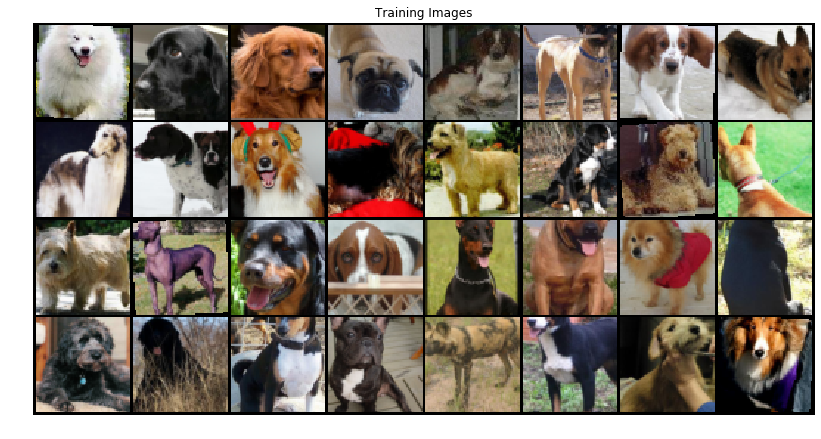

In [5]:
random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=5)]

transform = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('../input/all-dogs/', loader=doggo_loader, transform=transform)

data_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
    
real_batch = next(iter(data_loader))
plt.figure(figsize=(14, 14))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:32], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [6]:
def weights_init(m):
    '''custom weights initialization called on generator and discriminator'''
    
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Discriminator

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            
            # input is 3 x 64 x 64
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 128 x 32 x 32
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 256 x 16 x 16
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 512 x 8 x 8
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. 1024 x 4 x 4
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

Generator

In [8]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(128, 1024, 4, 1, 0, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            # state size. 1024 x 4 x 4
            
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 8 x 8
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 16 x 16
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 32 x 32
            
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
    
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


In [9]:
smoothed_real_label = 0.9
real_label = 1.0
fake_label = 0.0


def noise(size):
    ''' Generates a vector of gaussian sampled random values '''
    
    return torch.randn(size, 128, 1, 1, device=device)
    # return distribution.sample((size, 100, 1, 1)).to(device)


def smoothed_ones_target(size):
    ''' Tensor containing smoothed real_label (in [0.8; 1]), with shape = size '''
    
    return torch.rand(size, 1, device=device) / 5 + 0.8


def ones_target(size):
    ''' Tensor containing real_label, with shape = size '''
    
    return torch.full((size, 1), real_label, device=device)


def zeros_target(size):
    ''' Tensor containing fake_label, with shape = size '''
    
    return torch.full((size, 1), fake_label, device=device)

In [10]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0008, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0004, betas=(0.5, 0.999))

loss = nn.BCELoss()

In [11]:
def train_discriminator(optimizer, real_data, fake_data):
    
    N = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, smoothed_ones_target(N))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

In [12]:
def train_generator(optimizer, fake_data):
    
    N = fake_data.size(0)
    
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    error = loss(prediction, ones_target(N))
    error.backward()
    
    optimizer.step()
    
    return error

In [13]:
def plot_results(epoch, num_epochs, d_pred_real, d_pred_fake, fake):
    
    plt.figure(figsize=(12, 8))
    plt.title('Epoch: {} out of {}, D(x) = {}, D(G(z)) = {}'
              .format(epoch, num_epochs, '%.2f' % d_pred_real.mean().item(), '%.2f' % d_pred_fake.mean().item()))       
    plt.plot(d_loss, label='discriminator loss')
    plt.plot(g_loss, label='generator loss')     
    plt.legend(fontsize=15)
    plt.grid()
            
    plt.figure(figsize=(15, 4))
    plt.imshow(np.transpose(utils.make_grid(fake.to(device)[:16], padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


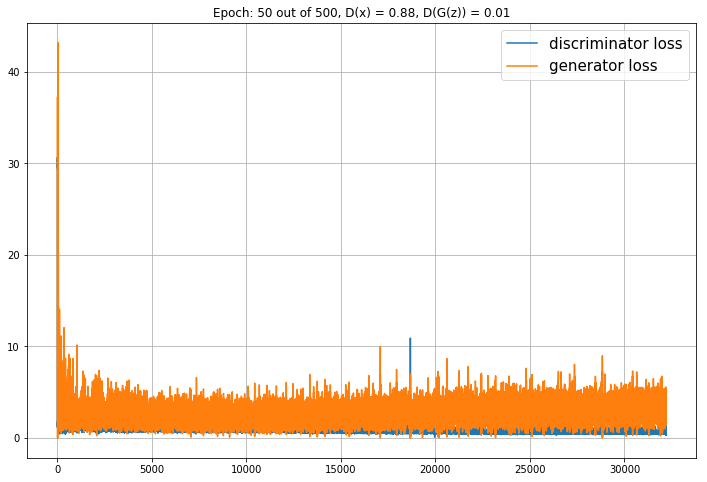

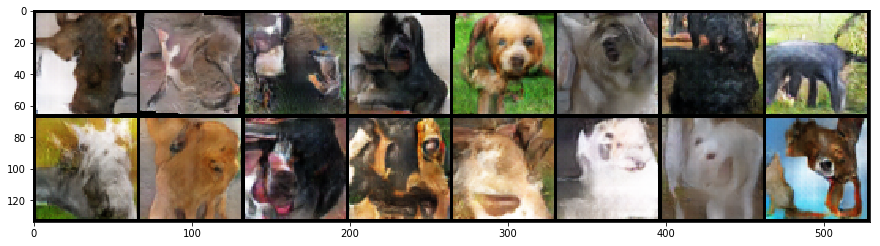

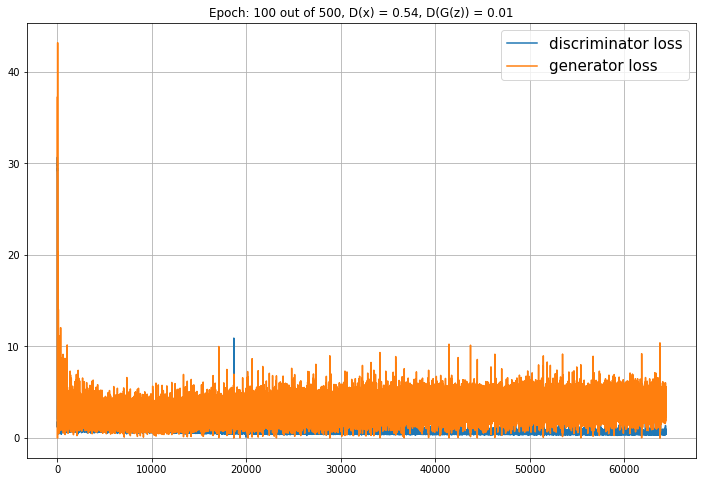

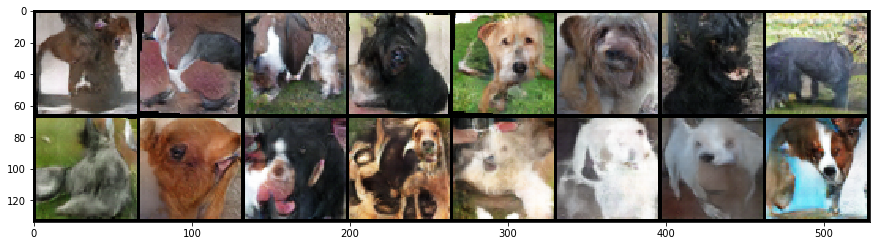

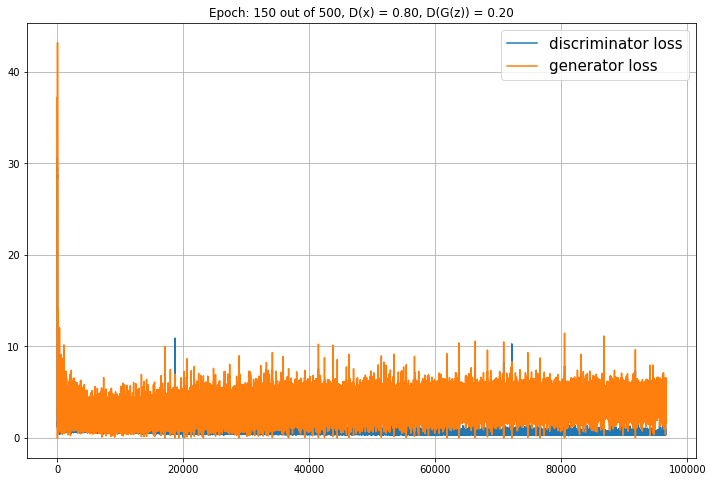

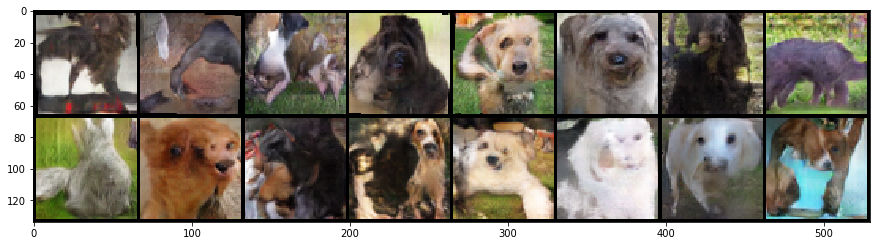

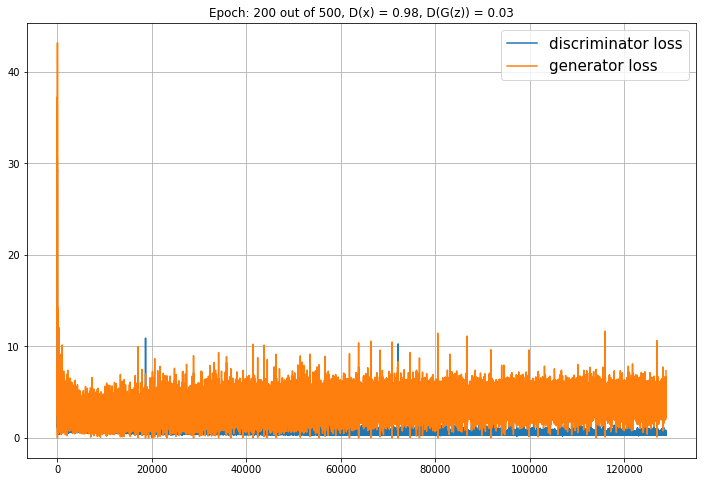

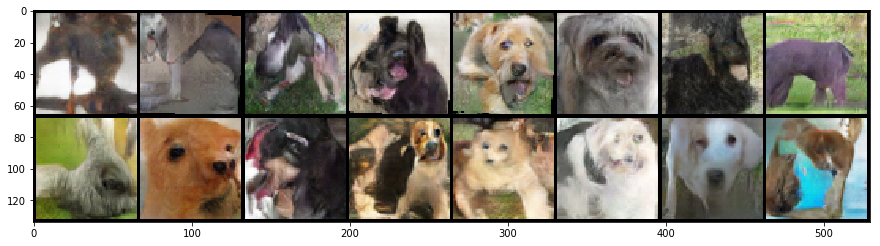

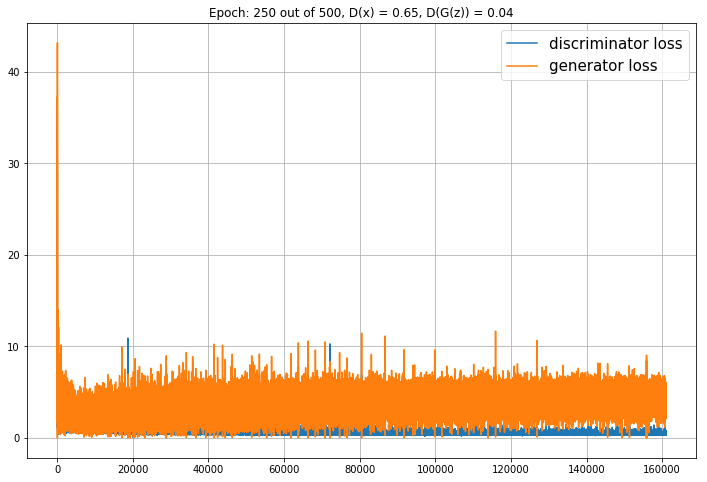

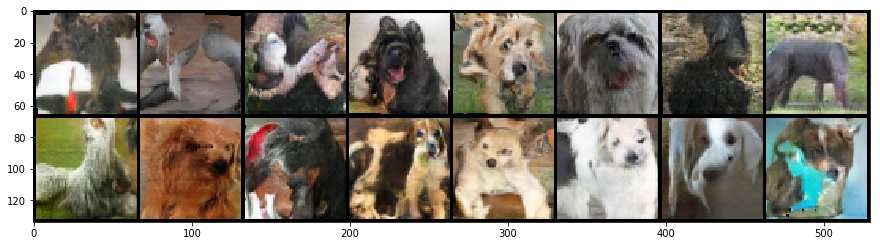

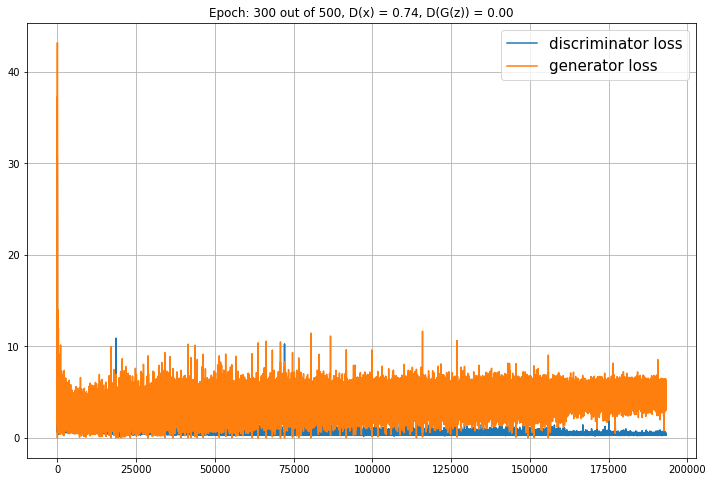

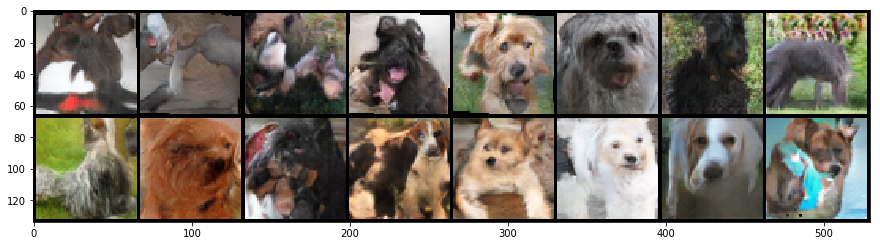

In [14]:
num_test_samples = 16

test_noise = noise(num_test_samples)

num_epochs = 500

d_loss, g_loss = [], []

for epoch in range(num_epochs):
    
    for real_batch, _ in data_loader:
        
        N = real_batch.size(0)
        real_batch = real_batch.to(device)
        
        ### Train Discriminator ###
        fake_batch = generator(noise(N)).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_batch, fake_batch)
        d_loss.append(d_error.item())

        ### Train Generator ###
        fake_batch = generator(noise(N))
        g_error = train_generator(g_optimizer, fake_batch)
        g_loss.append(g_error.item())
        
        
    if epoch == 250:
        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999))
        g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            fake = generator(test_noise).detach().cpu()
            plot_results(epoch + 1, num_epochs, d_pred_real, d_pred_fake, fake)
        
    if (epoch + 1) > 150 and time() - start > 32000:
        break

Save results

In [15]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
    
im_batch_size = 50
n_images = 10000

for i_batch in range(0, n_images, im_batch_size):

    gen_images = generator(noise(im_batch_size))
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    
    for i_image in range(gen_images.size(0)):
        save_image((gen_images[i_image, :, :, :] + 1.) / 2. , 
                   os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

'/kaggle/working/images.zip'